<a href="https://colab.research.google.com/github/abasnezhad/Kaggle/blob/main/Wine_Reviews_Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
import tensorflow_hub as hub

In [3]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
df=df.dropna(subset=['description', 'points'])

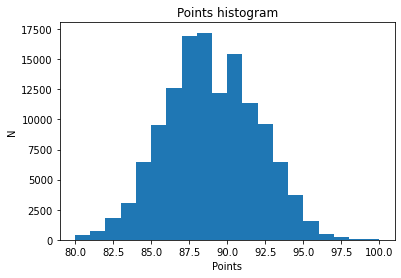

In [6]:
#histogram 

plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [7]:
df['label']=(df.points>=90).astype(int)

In [8]:
df=df[['description', 'label' ]]

In [9]:
train, val, test= np.split(df.sample(frac=1),[int(len(df)*0.8), int(len(df)*0.9 )])


In [10]:
# function that converts each training, validation, and test set DataFrame 
#into a tf.data.Dataset, then shuffles and batches the data. from ft toturial
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_data= df_to_dataset (train)
test_data= df_to_dataset (test)
val_data= df_to_dataset (val)

In [12]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Vibrant and straightforward, this opens with delicate aromas of Spanish broom, citrus fruit and herb. The bright, simple palate offers tangerine and a bitter almond note alongside zesty acidity.',
        b"This Merlot is dry, firm in tannins and earthy, with cherry, currant and tobacco flavors that finish in a swirl of spice. There's a rusticity to the tannins that strongly suggests drinking now.",
        b"From 100% Charbono, this offers hints of raspberry, cherry and orange on the nose, amid dense cherry and strawberry flavors that are concentrated and yet doesn't overwhelm the acidity. Medium body and weight make it a nice option for sipping and at the table.",
        ...,
        b'The 16th-century chateau of Saint Lager is on the slopes of the local landmark hill of Brouilly. The wine comes from vines below. It has spice, cherry and blueberry fruits with attractive acidity. The wine, still with a strong tannic edge, wil

In [13]:
# embedding and modeling

embedding= "https://tfhub.dev/google/nnlm-en-dim128/2"

hub_layer=hub.KerasLayer(embedding, dtype=tf.string, trainable= True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 128), dtype=float32, numpy=
array([[ 0.54019153, -0.2375146 ,  0.17228596, ..., -0.04290773,
         0.10181089, -0.04635577],
       [ 0.16742036, -0.18125235,  0.20593354, ..., -0.14069042,
         0.14182587,  0.00472806],
       [ 0.3485223 , -0.2039614 ,  0.16300939, ..., -0.20311783,
         0.23943353, -0.06749624],
       ...,
       [ 0.45825604, -0.1124588 ,  0.12652689, ..., -0.18979114,
         0.12786673, -0.00323014],
       [ 0.61560106, -0.14744605,  0.03495362, ..., -0.2668394 ,
         0.01481297,  0.00741277],
       [ 0.28524706, -0.10091499, -0.0221635 , ..., -0.17912327,
        -0.07511235,  0.2592685 ]], dtype=float32)>

In [15]:
model=tf.keras.Sequential()
model.add(hub_layer)
model.add( tf.keras.layers.Dense(16, activation="relu"))
model.add( tf.keras.layers.Dropout(0.4)) # prevening overfitting
model.add( tf.keras.layers.Dense(16, activation="relu"))
model.add( tf.keras.layers.Dropout(0.4)) # prevening overfitting
model.add( tf.keras.layers.Dense(1, activation="sigmoid"))

In [16]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [17]:
model.evaluate(train_data)

102/102 [==============================] - 3s 15ms/step - loss: 0.6925 - accuracy: 0.5243


[0.6924713850021362, 0.5242652297019958]

In [18]:
model.evaluate(val_data)

13/13 [==============================] - 0s 17ms/step - loss: 0.6924 - accuracy: 0.5219


[0.6923836469650269, 0.5218896865844727]

In [19]:
history=model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
102/102 [==============================] - 147s 1s/step - loss: 0.5907 - accuracy: 0.6633 - val_loss: 0.4567 - val_accuracy: 0.8004
Epoch 2/10
102/102 [==============================] - 144s 1s/step - loss: 0.4440 - accuracy: 0.7975 - val_loss: 0.4037 - val_accuracy: 0.8117
Epoch 3/10
102/102 [==============================] - 144s 1s/step - loss: 0.3903 - accuracy: 0.8391 - val_loss: 0.3930 - val_accuracy: 0.8216
Epoch 4/10
102/102 [==============================] - 144s 1s/step - loss: 0.3537 - accuracy: 0.8547 - val_loss: 0.3936 - val_accuracy: 0.8249
Epoch 5/10
102/102 [==============================] - 148s 1s/step - loss: 0.3264 - accuracy: 0.8655 - val_loss: 0.3982 - val_accuracy: 0.8207
Epoch 6/10
102/102 [==============================] - 147s 1s/step - loss: 0.3041 - accuracy: 0.8747 - val_loss: 0.4121 - val_accuracy: 0.8220
Epoch 7/10
102/102 [==============================] - 146s 1s/step - loss: 0.2847 - accuracy: 0.8821 - val_loss: 0.4255 - val_accuracy: 0.8222

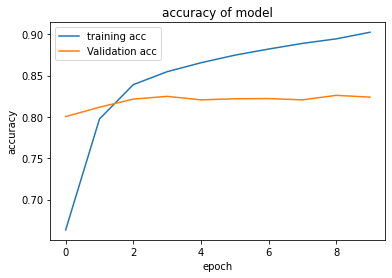

In [20]:
plt.plot(history.history['accuracy'], label='training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('accuracy of model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

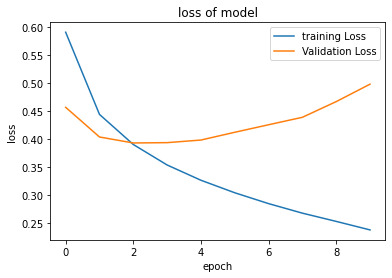

In [21]:
plt.plot(history.history['loss'], label='training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('loss of model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
model.evaluate(test_data )

13/13 [==============================] - 2s 176ms/step - loss: 0.4768 - accuracy: 0.8285


[0.476779580116272, 0.8285120725631714]

In [24]:
#LSTM
#encoding
encoder=tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, lable: text))

In [25]:
vocab=np.array(encoder.get_vocabulary())
vocab[:10 ]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine'],
      dtype='<U17')

In [27]:
model=tf.keras.Sequential([
                           encoder,
                           tf.keras.layers.Embedding(
                               input_dim=len(encoder.get_vocabulary()),
                               output_dim=32,
                               mask_zero=True
                           ),
                           tf.keras.layers.LSTM(32),
                           tf.keras.layers.Dense(32, activation='relu'),
                           tf.keras.layers.Dropout(0.4),
                           tf.keras.layers.Dense(1, activation= 'sigmoid')

                                  

])

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [30]:
model.evaluate(train_data)
model.evaluate(val_data)

13/13 [==============================] - 2s 189ms/step - loss: 0.6934 - accuracy: 0.4533


[0.693416953086853, 0.4532584547996521]

In [33]:
history=model.fit(train_data, epochs=5, validation_data= val_data)

Epoch 1/5
102/102 [==============================] - 64s 534ms/step - loss: 0.5471 - accuracy: 0.7103 - val_loss: 0.3848 - val_accuracy: 0.8248
Epoch 2/5
102/102 [==============================] - 56s 550ms/step - loss: 0.3644 - accuracy: 0.8362 - val_loss: 0.3602 - val_accuracy: 0.8341
Epoch 3/5
102/102 [==============================] - 54s 532ms/step - loss: 0.3492 - accuracy: 0.8443 - val_loss: 0.3597 - val_accuracy: 0.8326
Epoch 4/5
102/102 [==============================] - 54s 528ms/step - loss: 0.3402 - accuracy: 0.8480 - val_loss: 0.3588 - val_accuracy: 0.8367
Epoch 5/5
102/102 [==============================] - 54s 527ms/step - loss: 0.3351 - accuracy: 0.8508 - val_loss: 0.3589 - val_accuracy: 0.8356


In [34]:
model.evaluate(test_data)

13/13 [==============================] - 2s 187ms/step - loss: 0.3452 - accuracy: 0.8407


[0.34516680240631104, 0.8406677842140198]